In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Searching for TATA-like boxes in the lacZYA promoter

In [6]:
def count_strong_matches(seq1, seq2, key_sites):

    matched = True
    for i in key_sites:
        if seq1[i] != seq2[i]:
            matched = False
    
    if matched:    
        n_matches = 0
        for ii in range(len(seq1)):
            if ii not in key_sites:
                if seq1[ii] == seq2[ii]:
                    n_matches += 1
    else:
        n_matches = -1

    return n_matches

In [7]:
def search_tata_strong(seqs, key_sites):

    matches = np.zeros(len(key_sites) + 1)
    matches_pos = np.zeros((len(key_sites) + 1, 160))

    for seq in seqs:
        seq = seq.upper()
        for i in range(len(seq) - 6):
            window = seq[i:(i+6)]
            m = count_strong_matches(window, 'TATAAT', key_sites)
            matches[m] += 1
            matches_pos[m, i] += 1

    return matches, matches_pos

In [8]:
matches, pos = search_tata_strong([promoter], [0, 1, 5])

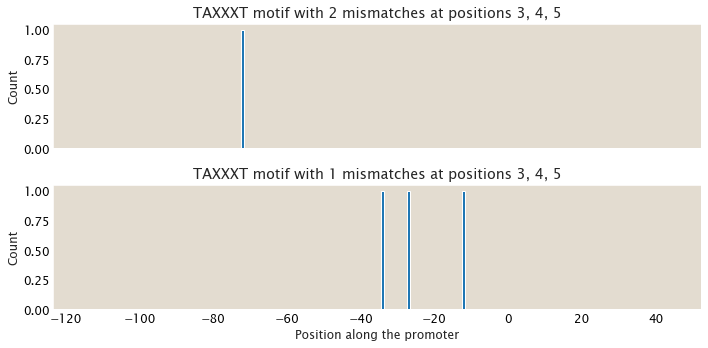

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10,5),
                         sharex=True)
for i in range(2):
    axes[i].bar(np.arange(-115, 45), pos[:2][i, :])
    axes[i].set_title('TAXXXT motif with {} mismatches at positions 3, 4, 5'.format(2-i))
    axes[i].set_ylabel('Count', fontsize=12)

axes[-1].set_xlabel('Position along the promoter', fontsize=12)

plt.tight_layout()
plt.show()

Let's slide the energy matrix for RNAP and plot the binding energy at each site.

In [10]:
l_energy = []
for i in range(160 - len(rnap_site)):
    subseq = promoter[i:(i + len(rnap_site))].upper()
    binding_energy = tregs.simulate.get_d_energy(subseq, rnap_emat, e_wt=-2.9)
    l_energy.append(binding_energy)

As a first pass, we ignore the cases that the RNAP and the repressor can bind at the same site.

In [11]:
rnap_emat.shape

(41, 4)

In [12]:
rep_emat.shape

(21, 4)

In [13]:
def simrep_pbound(promoter_variant, rep_site, p_emat, r_emat, n_p, n_r, n_NS,
                  ep_wt=0, er_wt=0):

    w_rnap_tot = 0
    for i in range(160 - p_emat.shape[0]):
        subseq = promoter_variant[i:(i + p_emat.shape[0])].upper()
        w_rnap = tregs.simulate.get_weight(subseq, p_emat, e_wt=ep_wt)
        w_rnap_tot += w_rnap

    w_r = tregs.simulate.get_weight(rep_site, r_emat, e_wt=er_wt)

    return (n_p / n_NS * w_rnap_tot) / (1 + n_p / n_NS * w_rnap_tot + n_r / n_NS * w_r)

In [14]:
def simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                  rnap_emat, O1_emat, n_p, n_r, n_NS,
                  ep_wt, er_wt):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rv['pbound'] = simrep_pbound(mut, mut[rep_start:rep_end].upper(), rnap_emat, O1_emat,
                                     n_p, n_r, n_NS,
                                     ep_wt=ep_wt, er_wt=er_wt)
        l_tr.append(rv)
    df_simrep = pd.DataFrame.from_records(l_tr)

    return df_simrep


def get_dna_cnt(n_seqs):

    dna_cnt = np.random.exponential(1, size=n_seqs) * 10

    dna_cnt_up = []
    for cnt in dna_cnt:
        dna_cnt_up.append(math.ceil(cnt))

    return dna_cnt


def simrep(wtseq, rnap_wtseq, rep_wtseq, rnap_emat, rep_emat, 
           ep_wt, er_wt, n_NS, n_p, n_r,
           num_mutants=10000, mutrate=0.1, scaling_factor=100):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=mutrate,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq,rep_wtseq)

    df_simrep = simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                          rnap_emat, rep_emat, n_p, n_r, n_NS,
                          ep_wt, er_wt)
    
    dna_cnt = get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    df_simrep['ct_1'] = 0.1 + df_simrep['ct_0'] * df_simrep['pbound'] * scaling_factor
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(int)

    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

In [15]:
n_NS = len(genome)
n_p = 4600
n_r = 10

ep_wt = -5
er_wt = -15

df = simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
            ep_wt, er_wt, n_NS, n_p, n_r)

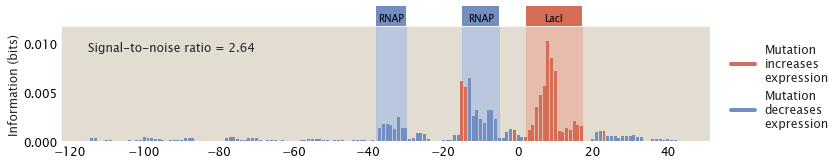

In [16]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               up_scaling_factor=1.5,
                               outfile='../../manuscript/figures/plots/fig13/simrep_footprint_spurious_binding.png')

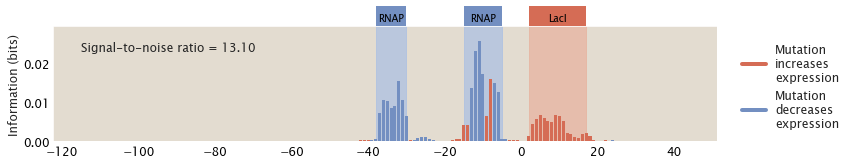

In [17]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               up_scaling_factor=1.5,
                               outfile='../../manuscript/figures/plots/fig13/simrep_footprint_control.png')